# -- Part 3 -- Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the option)

Book version : https://www.learnpytorch.io/02_pytorch_classification/


## 1. Make classification data and get it ready

In [122]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [123]:
len(X), len(y)

(1000, 1000)

In [124]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [125]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "x2": X[:, 0],
                       "label": y})
circles.head(10)

,X1,x2,label
0,0.754246,0.754246,1
1,-0.756159,-0.756159,1
2,-0.815392,-0.815392,1
3,-0.393731,-0.393731,1
4,0.442208,0.442208,0
5,-0.479646,-0.479646,1
6,-0.013648,-0.013648,1
7,0.771513,0.771513,1
8,-0.169322,-0.169322,1
9,-0.121486,-0.121486,0


In [126]:
circles.label.value_counts()

,count
label,
1,500
0,500


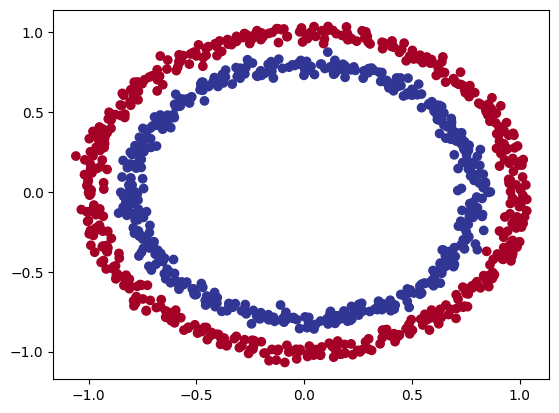

In [127]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: the data we're working with is often reffered to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [128]:
X.shape, y.shape

((1000, 2), (1000,))

In [129]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [130]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [131]:
import torch

In [132]:
type(X), X.dtype # ATTENTION : Float 64 here

(numpy.ndarray, dtype('float64'))

In [133]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # <- from numpy array to tensor, then Float 32 conversion
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [134]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [135]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 0.2 means 20% of data will be test (80% will be train)
                                                    random_state=42
                                                    )

In [136]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots

To do so, we want to:
1. Setup device agnostic code so our code will run on a GPU accelerator if there is one
2. Contsruct a model (by sublassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [137]:
import torch
from torch import nn

# Make device agnistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnoistic code, let's create a model that:

1. Subclasses `nn.Module`(almost all models in PyTorch subclass `nn.Module`)
2. Creates 2 `nn.Linear()`layers that are capable of handling the shapes of our data
3. Defines a `forward()`method that outlines the forward pass (or forward computation) of the model
4. Instantiates an instance of our model class and send it to the target device

In [138]:
X_train.shape

torch.Size([800, 2])

In [139]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create two nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscale to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and aoutputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x --> layer_1 --> layer_2 --> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [140]:
next(model_0.parameters()).device

device(type='cpu')

In [141]:
# Let's replicate the model above using nn.Sequential()
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [142]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4830, -0.5999],
                      [-0.3894, -0.6189],
                      [-0.4502,  0.7068],
                      [ 0.1336,  0.2179],
                      [-0.6595, -0.4644]])),
             ('layer_1.bias',
              tensor([-0.2354,  0.1106, -0.6222, -0.3047, -0.4233])),
             ('layer_2.weight',
              tensor([[ 0.0012, -0.1664, -0.0310, -0.3030, -0.3070]])),
             ('layer_2.bias', tensor([-0.2609]))])

In [143]:
# Make some prediction with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
  print(f"First 10 predictions:\n{torch.round(untrained_preds[:10])}") # Round it up to make it 1 or 0 (format of the expected output)
  print(f"First test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions:
tensor([[-0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]])
First test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [144]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

**Which loss function or optimizer should you use?**

Again... this is problem specific

For example for regression (predicting a number) you might want MAE or MSE (Mean Absolute Error or Mean Squared Error)

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how wrong your model's predeictions are

And for optimizers, two of the most common and useful are SDG and Adam, however PyTorch has many built in options.

* For the loss function we're going to use the `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check article online (towardsdatascience.com)
* For different optimizers see `torch.optim`

In [145]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [146]:
# Calculate accuracy - out of a 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

**To train our model, we're going to need to build a training loop**

1. Forward pass
2. Calculate the loss
3. Optimizer Zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going ti be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [147]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0210],
        [ 0.1162],
        [-0.2562],
        [ 0.0451],
        [-0.0581]])

In [148]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [149]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4947],
        [0.5290],
        [0.4363],
        [0.5113],
        [0.4855]])

**For our prediction probability values, we need to perform a range-style rounding on them:**
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [150]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> prediction probability -> prediction labels )
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([0., 1., 0., 1., 0.])

In [151]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building and training a testing loop


In [152]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
  y_predictions = torch.round(torch.sigmoid(y_logits)) # Turn logits _> predictions probabilities (pred probs) -> prediction labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                  y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_predictions)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                            y_pred = test_predictions)

  # Print out what's hapening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.72008, Acc: 50.00 | Test loss: 0.71732, Test acc: 50.00
Epoch: 10 | Loss: 0.70288, Acc: 50.00 | Test loss: 0.70209, Test acc: 50.00
Epoch: 20 | Loss: 0.69712, Acc: 50.00 | Test loss: 0.69711, Test acc: 50.00
Epoch: 30 | Loss: 0.69508, Acc: 45.62 | Test loss: 0.69544, Test acc: 45.50
Epoch: 40 | Loss: 0.69427, Acc: 49.25 | Test loss: 0.69487, Test acc: 45.00
Epoch: 50 | Loss: 0.69389, Acc: 50.00 | Test loss: 0.69466, Test acc: 44.50
Epoch: 60 | Loss: 0.69367, Acc: 49.50 | Test loss: 0.69458, Test acc: 47.50
Epoch: 70 | Loss: 0.69352, Acc: 49.25 | Test loss: 0.69456, Test acc: 49.00
Epoch: 80 | Loss: 0.69341, Acc: 50.12 | Test loss: 0.69455, Test acc: 49.50
Epoch: 90 | Loss: 0.69333, Acc: 49.62 | Test loss: 0.69455, Test acc: 49.50


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make them visual!

In other terms : Visualize!!

To do so, we're going to import a function called `plot_decision_boundry()`

In [181]:
import requests
from pathlib import Path

# Download helper function from learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


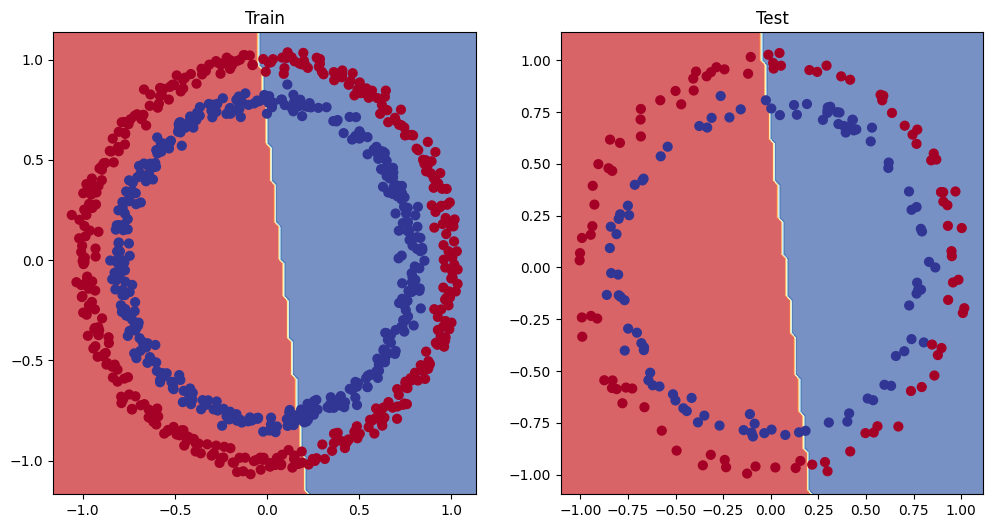

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* **Add more layers** - give the model more chances to learn about patterns in the data
* **Add more hidden units** - go from 5 hidden units to 10 hidden units
* **Fit for longer** - more epochs
* **Changing the activation function**
* **Change the learning rate**
* **Change the loss function**

These options are all from a model's perspective because the deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are reffered as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Inscrease the number of layer: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(in_features=2, out_features=10)
      self.layer_2 = nn.Linear(in_features=10, out_features=10)
      self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
      # z = self.layer_1(x) # "z" means "logits"
      # z = self.layer_2(z)
      # z = self.layer_3(z)
      return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()

  #1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_predictions = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train) # we use logits because of the BCEWithLogitsLoss function
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_predictions)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_predictions)

    # Print our what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 100 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 200 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 300 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 400 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 500 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 600 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 700 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 800 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epoch: 900 | Loss:0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00


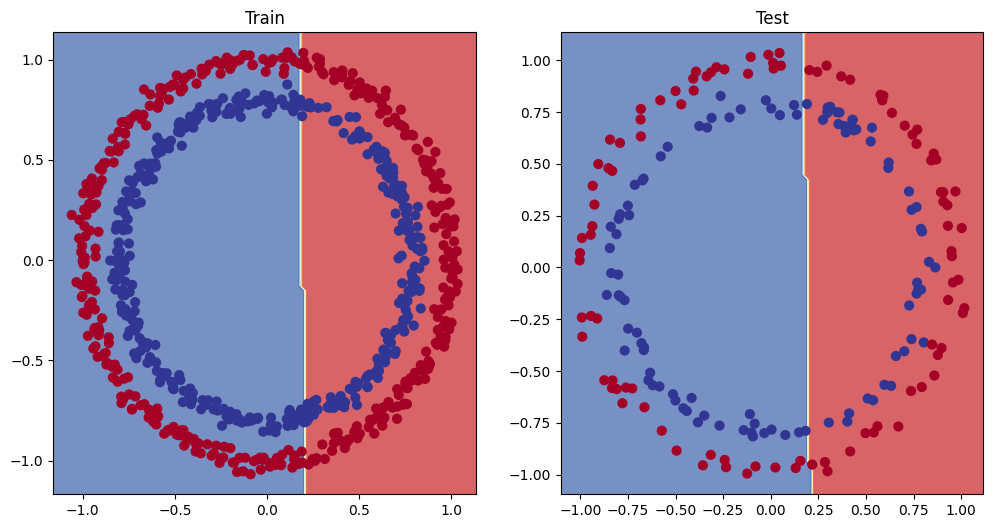

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshootto a larger problem is to test out a smaller problem

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check out the length of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

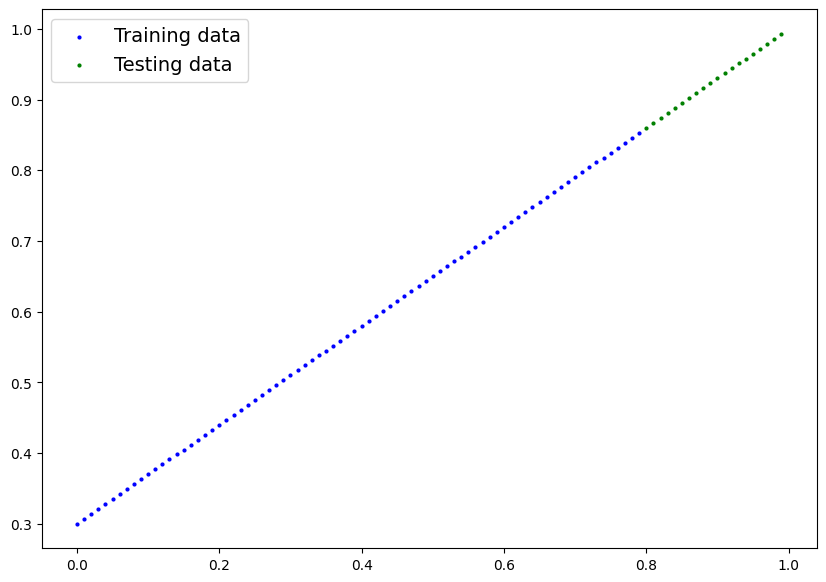

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjusting `model_1`to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2, next(model_2.parameters()).device

(Sequential(
   (0): Linear(in_features=1, out_features=10, bias=True)
   (1): Linear(in_features=10, out_features=10, bias=True)
   (2): Linear(in_features=10, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the numer of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print our what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


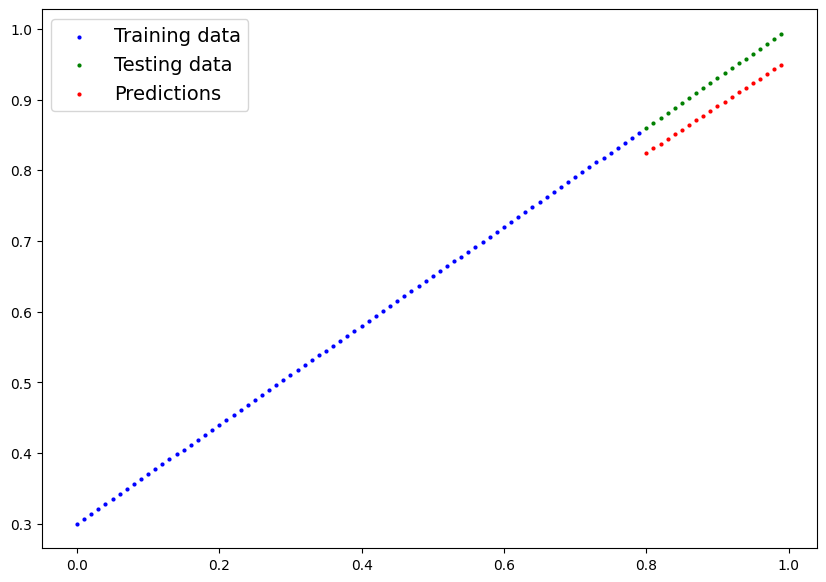

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot datza and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non straight line?"

Or in machine learning terms, an infinite amount (but really it is finite) of linear and non linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

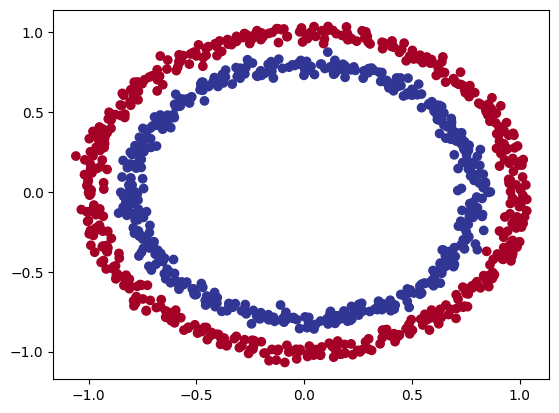

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Splitinto train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = Non straight lines

Artificial neural networks are a large combination of linear (straight) and non-linear (non-straight) functions which are potentially able to find patterns in data.

In [ ]:
# Build a model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training. amodel with non-linearity

In [ ]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_predictions = torch.round(torch.sigmoid(y_logits)) # logits -> predictions probabilities -> prediction labels

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_predictions)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_predictions = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_predictions)

  ### Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.6929, Acc: 50.00 | Test loss: 0.6932, Test acc: 50.00
Epoch: 100 | Loss: 0.6912, Acc: 52.88 | Test loss: 0.6910, Test acc: 52.50
Epoch: 200 | Loss: 0.6898, Acc: 53.37 | Test loss: 0.6894, Test acc: 55.00
Epoch: 300 | Loss: 0.6879, Acc: 53.00 | Test loss: 0.6872, Test acc: 56.00
Epoch: 400 | Loss: 0.6852, Acc: 52.75 | Test loss: 0.6841, Test acc: 56.50
Epoch: 500 | Loss: 0.6810, Acc: 52.75 | Test loss: 0.6794, Test acc: 56.50
Epoch: 600 | Loss: 0.6751, Acc: 54.50 | Test loss: 0.6729, Test acc: 56.00
Epoch: 700 | Loss: 0.6666, Acc: 58.38 | Test loss: 0.6632, Test acc: 59.00
Epoch: 800 | Loss: 0.6516, Acc: 64.00 | Test loss: 0.6476, Test acc: 67.50
Epoch: 900 | Loss: 0.6236, Acc: 74.00 | Test loss: 0.6215, Test acc: 79.00


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_predictions = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_predictions[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

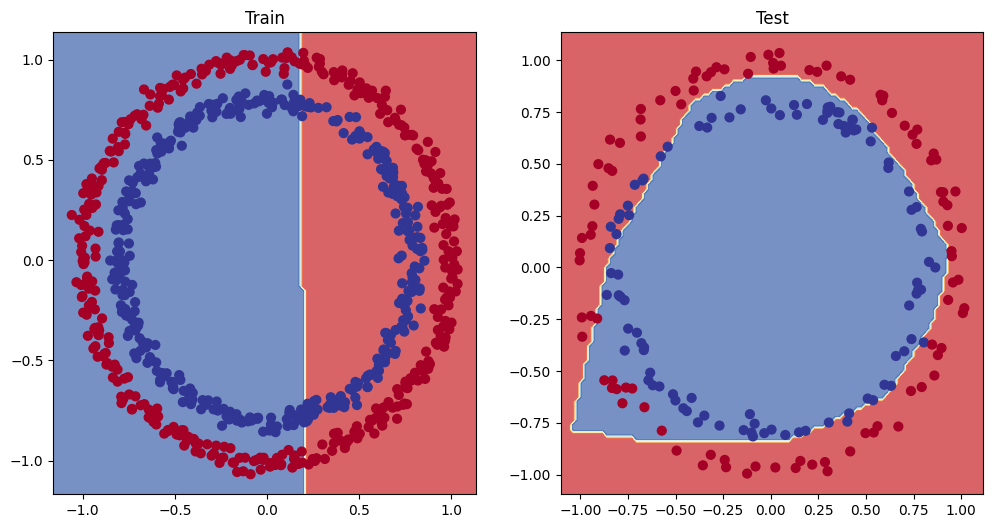

In [ ]:
# Plot decision boudaries
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, # Model_1 has no non-linearity
                       X_train,
                       y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, # Model_3 has non-linearity
                       X_test,
                       y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are **linear** and **non-linear** functions

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

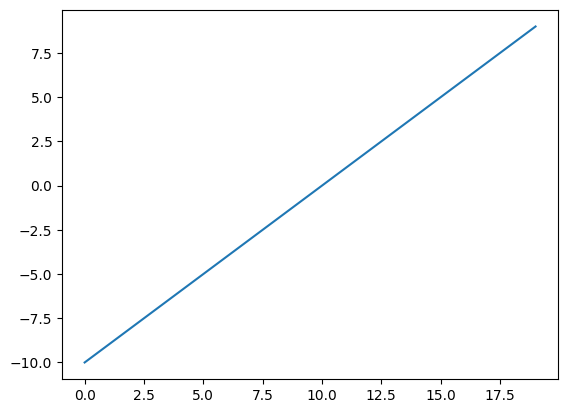

In [ ]:
# Visualize the tensor
plt.plot(A)

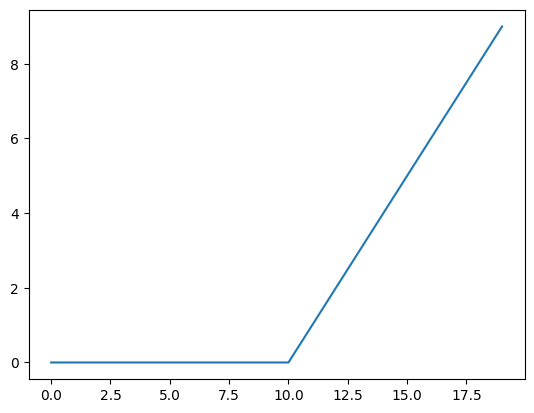

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [ ]:
def relu(x: torch.Tensor)-> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

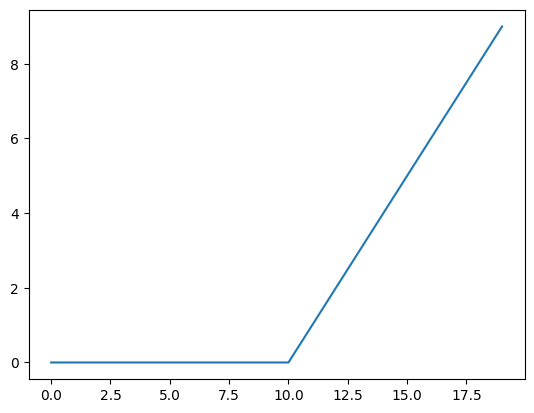

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A))

In [ ]:
# Now let's. dothe same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

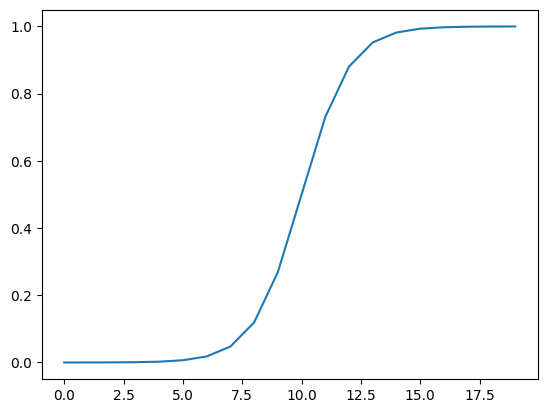

In [ ]:
plt.plot(torch.sigmoid(A))

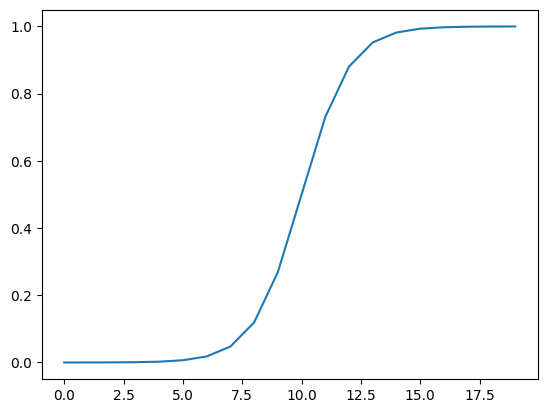

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one this or another (cat vs dog, spam vs not-spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

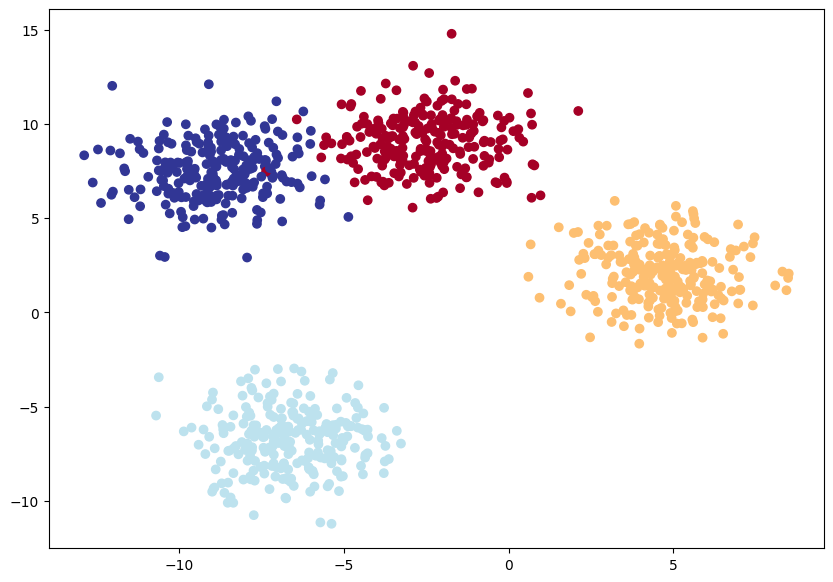

In [ ]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Setthe hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # Give the class a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot the data (visualize!)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model

    Args:
      input_features (int) : Number of input features to the model
      output_features (int) : Number of output features (number of output classes)
      hidden_units (int):

    Returns:
    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
# Create a loss function for multi-class classification (measures how wrong our model's predictions are)
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification (updates our model parameters to try and reduce the loss)
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

**Logits** (raw output of the model) -> **Pred probs** (use `torch.softmax`) -> **Pred labels** (take the argmax of the prediction probabilities)

In [ ]:
# Let's get some raw outputs of our model (logits)
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
# Convert our model's logits outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [ ]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
y_blob_train.dtype, y_logits.dtype

(torch.int64, torch.float32)

In [ ]:
# Fit the multi-class model ti the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop though data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  ## Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    #print(test_logits.shape, y_blob_test.shape)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.1588, Acc: 40.38 | Test loss: 1.0755, Test acc: 48.00
Epoch: 10 | Loss: 0.6448, Acc: 96.75 | Test loss: 0.6607, Test acc: 97.50
Epoch: 20 | Loss: 0.4254, Acc: 98.50 | Test loss: 0.4307, Test acc: 100.00
Epoch: 30 | Loss: 0.2529, Acc: 99.12 | Test loss: 0.2451, Test acc: 99.50
Epoch: 40 | Loss: 0.1123, Acc: 99.25 | Test loss: 0.1023, Test acc: 99.50
Epoch: 50 | Loss: 0.0663, Acc: 99.25 | Test loss: 0.0585, Test acc: 99.50
Epoch: 60 | Loss: 0.0507, Acc: 99.25 | Test loss: 0.0429, Test acc: 99.50
Epoch: 70 | Loss: 0.0430, Acc: 99.25 | Test loss: 0.0349, Test acc: 99.50
Epoch: 80 | Loss: 0.0384, Acc: 99.25 | Test loss: 0.0299, Test acc: 99.50
Epoch: 90 | Loss: 0.0352, Acc: 99.25 | Test loss: 0.0266, Test acc: 99.50


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predicitons
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]


tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [ ]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]])

In [ ]:
# Go from prediction probabilities -> Prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

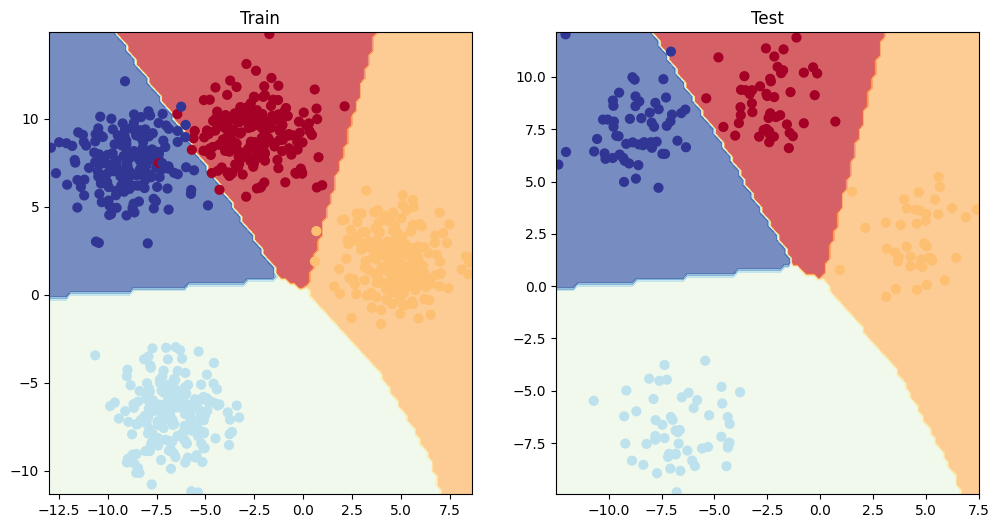

In [ ]:
# Plot decision boudaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,
                       X_blob_train,
                       y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,
                       X_blob_test,
                       y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - Out of a 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

If you want access to a lot of PyTorch metrics, see TorchMetrics

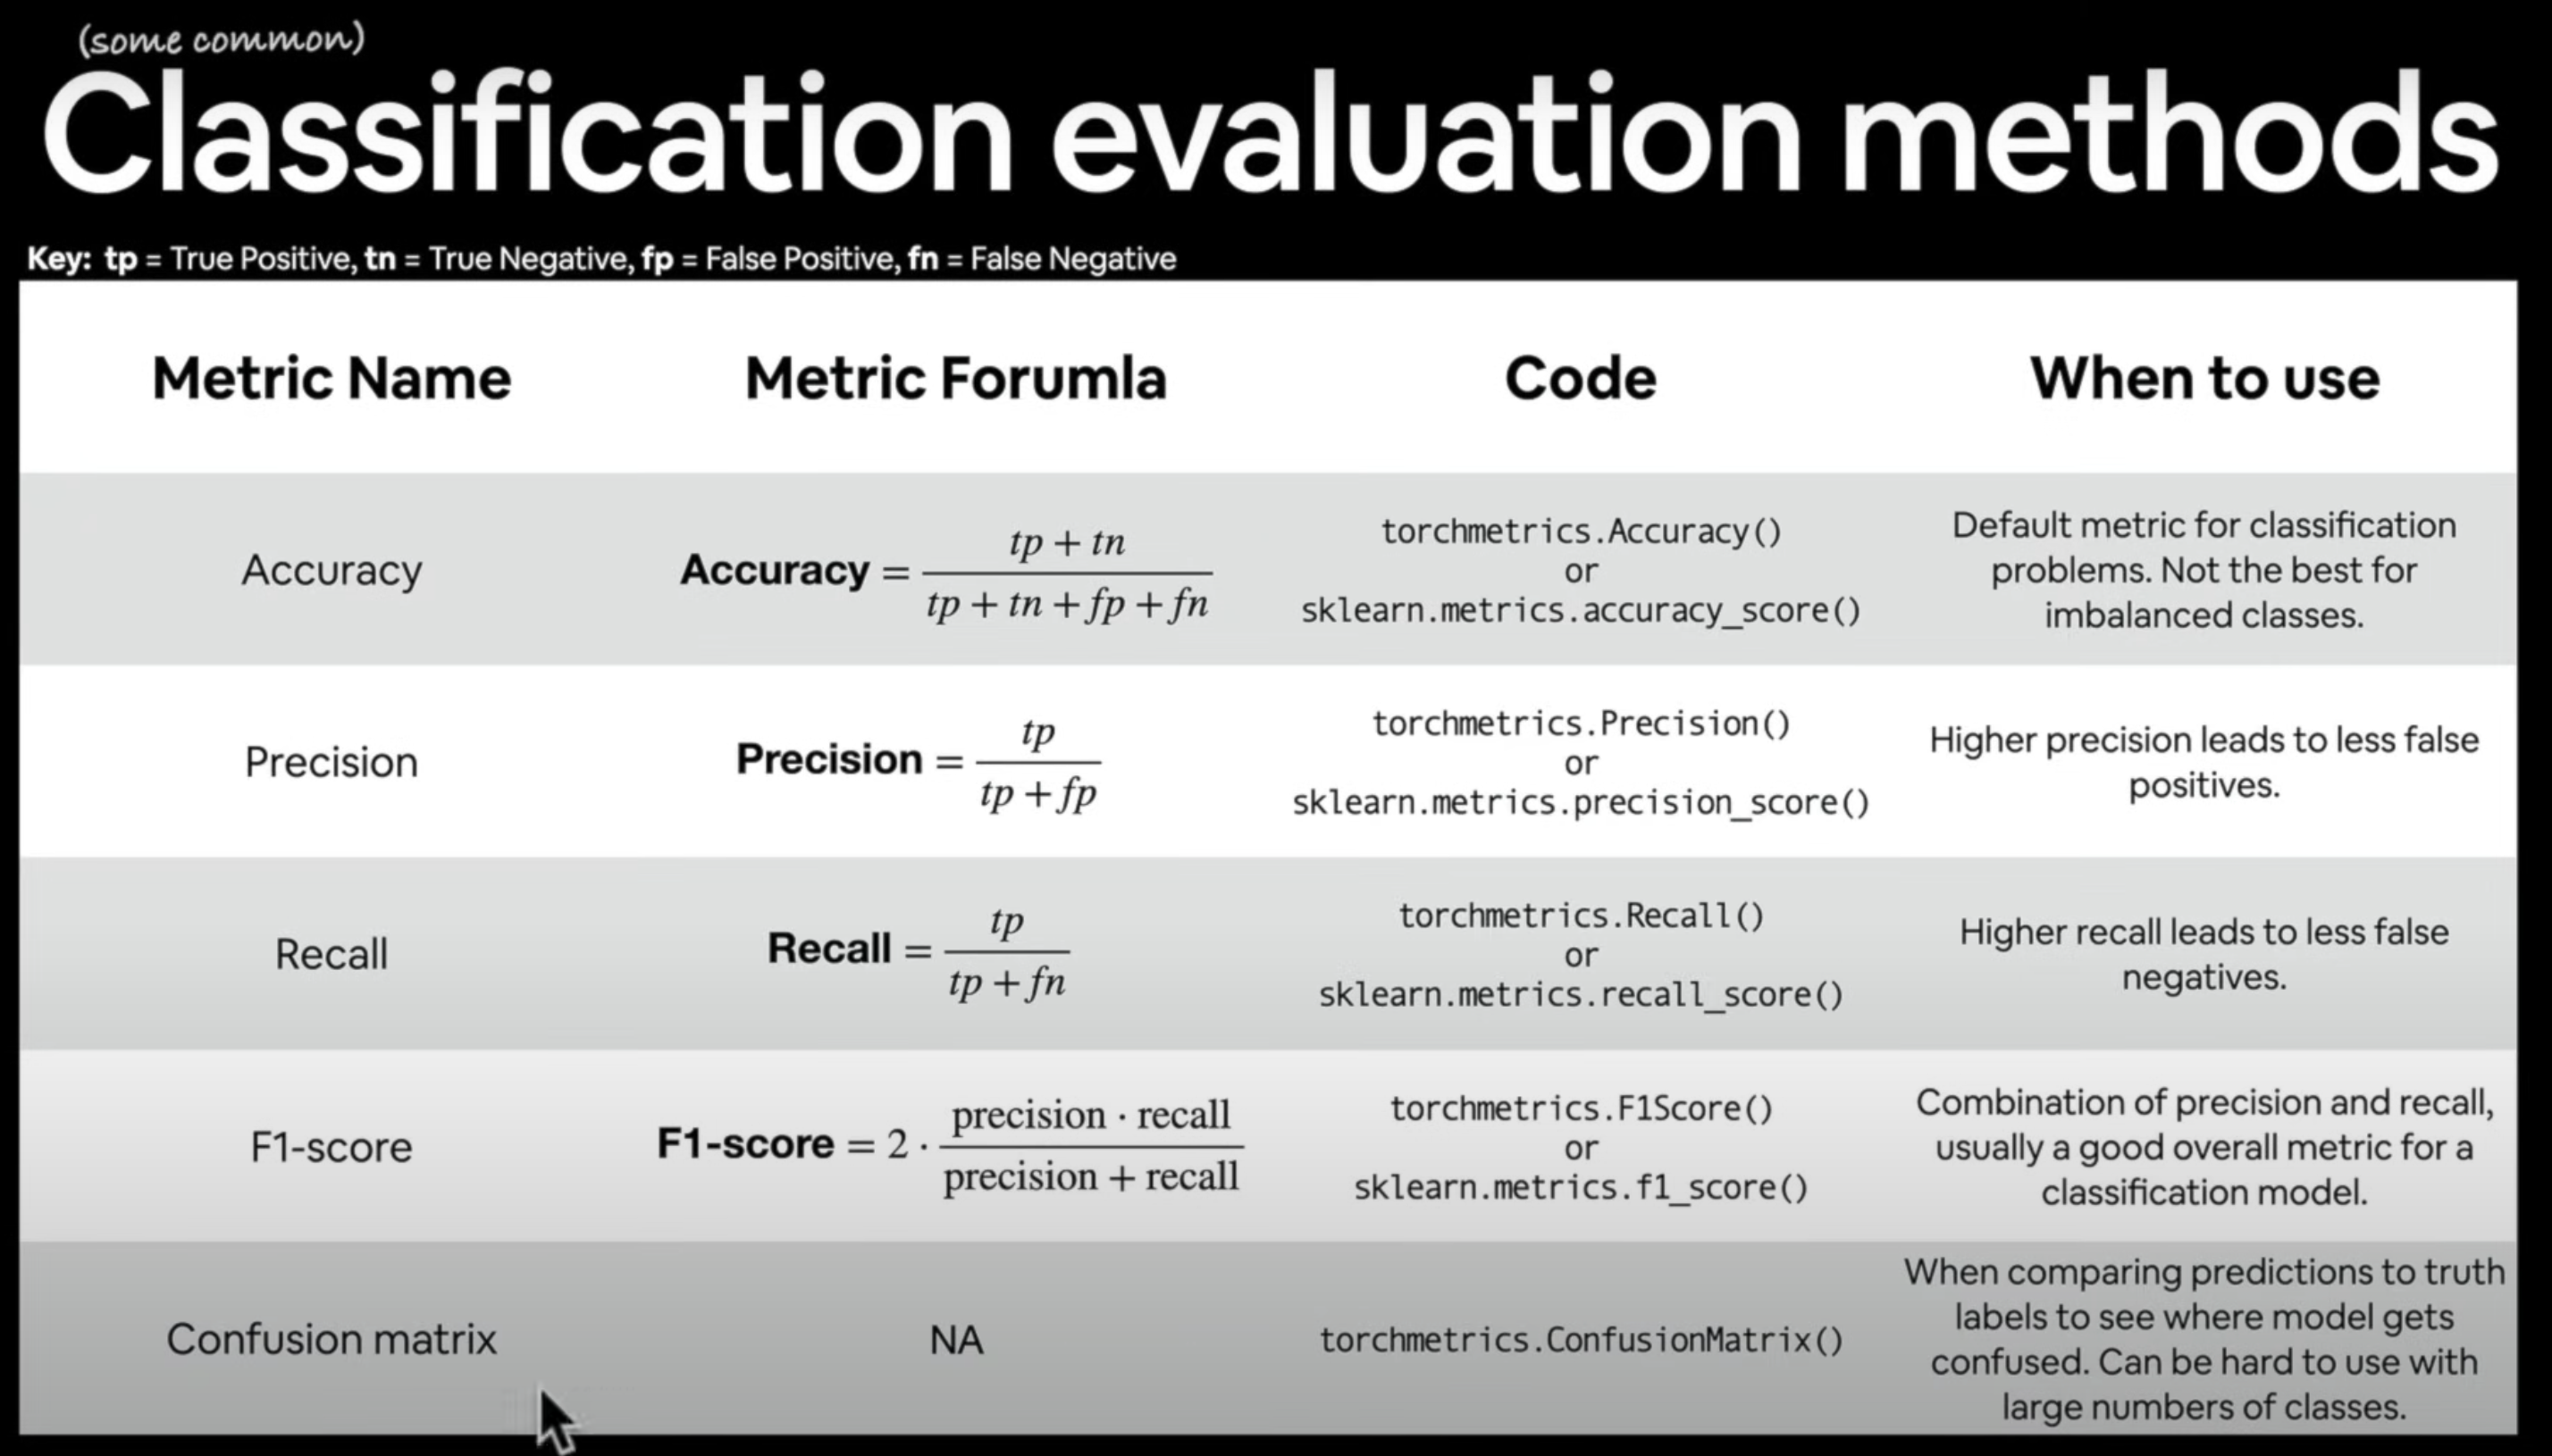

In [109]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [110]:
from torchmetrics import Accuracy

# Setup metrics
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
print(torchmetric_accuracy(y_preds, y_blob_test))
print(accuracy_fn(y_blob_test, y_preds)) # just to compare with our previous accuracy method

tensor(0.9950)
99.5


# Exercices

In [153]:
# Import torch
import torch

# Setup device agnostic code


# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors.
* Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [154]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000,
                            noise=0,
                            random_state=RANDOM_SEED)

X[:5], y[:5]

(array([[ 0.00872719,  0.36817352],
        [ 0.921384  , -0.49690497],
        [ 0.94022577, -0.49821192],
        [ 0.46587532, -0.34540571],
        [-0.85041204,  0.52611726]]),
 array([1, 1, 1, 1, 0]))

In [155]:
# Turn data into a DataFrame
import pandas as pd

moons = pd.DataFrame({"X1": X[:, 0],
                        "x2": X[:, 0],
                       "label": y})
moons.head(10)

,X1,x2,label
0,0.008727,0.008727,1
1,0.921384,0.921384,1
2,0.940226,0.940226,1
3,0.465875,0.465875,1
4,-0.850412,-0.850412,0
5,0.564901,0.564901,1
6,0.298480,0.298480,1
7,0.003347,0.003347,1
8,1.636065,1.636065,1
9,0.655293,0.655293,0


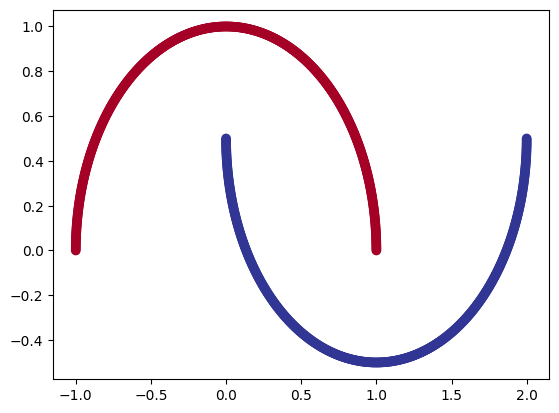

In [156]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [157]:
# Turn data into tensors of dtype float

X = torch.from_numpy(X).type(torch.float) # <- from numpy array to tensor, then Float 32 conversion
y = torch.from_numpy(y).type(torch.float)

X.shape, y.shape, X[:5], y[:5]

(torch.Size([1000, 2]),
 torch.Size([1000]),
 tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454],
         [-0.8504,  0.5261]]),
 tensor([1., 1., 1., 1., 0.]))

In [160]:
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 0.2 means 20% of data will be test (80% will be train)
                                                    random_state=RANDOM_SEED
                                                    )

X_train.shape, X_train[:5], y_train.shape, y_train[:5], X_test.shape, X_test[:5], y_test.shape, y_test[:5],

(torch.Size([800, 2]),
 tensor([[ 1.9469,  0.1784],
         [-0.9174,  0.3979],
         [-0.0786,  0.9969],
         [-0.1162,  0.9932],
         [ 0.3737, -0.2796]]),
 torch.Size([800]),
 tensor([1., 0., 0., 0., 1.]),
 torch.Size([200, 2]),
 tensor([[ 0.4982, -0.3650],
         [ 0.6879,  0.7258],
         [ 1.2155, -0.4765],
         [ 0.5760,  0.8174],
         [ 1.8788,  0.0229]]),
 torch.Size([200]),
 tensor([1., 0., 1., 0., 1.]))

In [161]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [162]:
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class ExerciseMoonModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_features=8):
    super().__init__()

    self.linear_layer_stack = self.layers = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

exo_model = ExerciseMoonModel(in_features=2, out_features=1)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [163]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(exo_model.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [164]:
# Calculate accuracy - out of a 100 examples, what percentage does our model get right?
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [165]:
y_train[:5], X_train[:5]

(tensor([1., 0., 0., 0., 1.]),
 tensor([[ 1.9469,  0.1784],
         [-0.9174,  0.3979],
         [-0.0786,  0.9969],
         [-0.1162,  0.9932],
         [ 0.3737, -0.2796]]))

In [190]:
epochs = 100

for epoch in range(epochs):
  exo_model.train()

  y_logits = exo_model(X_train).squeeze()
  y_predictions = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_predictions, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  exo_model.eval()
  with torch.inference_mode():
    test_logits = exo_model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_preds, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.0232, Acc: 100.00 | Test loss: 0.0232, Test acc: 100.00
Epoch: 10 | Loss: 0.0228, Acc: 100.00 | Test loss: 0.0228, Test acc: 100.00
Epoch: 20 | Loss: 0.0224, Acc: 100.00 | Test loss: 0.0224, Test acc: 100.00
Epoch: 30 | Loss: 0.0220, Acc: 100.00 | Test loss: 0.0220, Test acc: 100.00
Epoch: 40 | Loss: 0.0216, Acc: 100.00 | Test loss: 0.0216, Test acc: 100.00
Epoch: 50 | Loss: 0.0212, Acc: 100.00 | Test loss: 0.0213, Test acc: 100.00
Epoch: 60 | Loss: 0.0209, Acc: 100.00 | Test loss: 0.0209, Test acc: 100.00
Epoch: 70 | Loss: 0.0205, Acc: 100.00 | Test loss: 0.0206, Test acc: 100.00
Epoch: 80 | Loss: 0.0202, Acc: 100.00 | Test loss: 0.0202, Test acc: 100.00
Epoch: 90 | Loss: 0.0199, Acc: 100.00 | Test loss: 0.0199, Test acc: 100.00


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()`function created in this notebook.

In [192]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

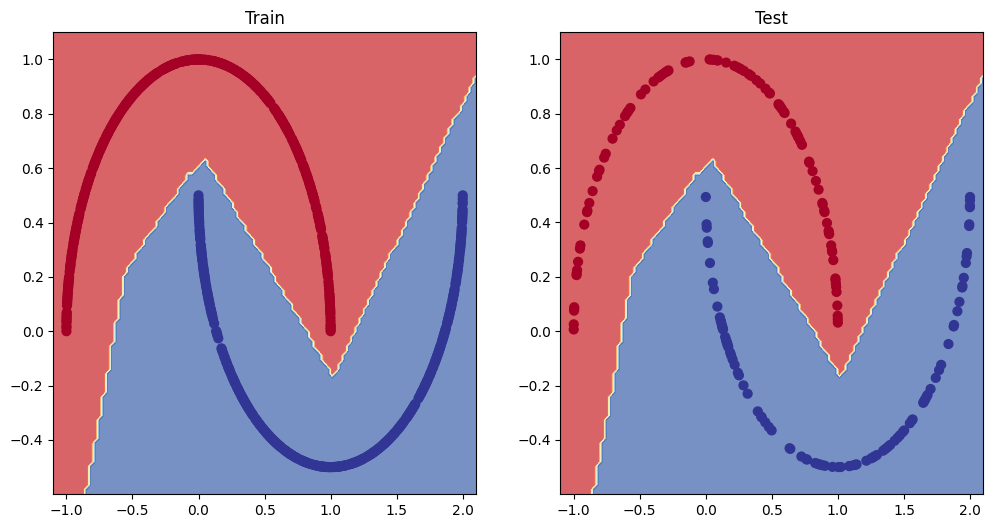

In [193]:
# Plot decision boudaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(exo_model,
                       X_train,
                       y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(exo_model,
                       X_test,
                       y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
* Feel free to reference the ML cheatsheet website for the formula.

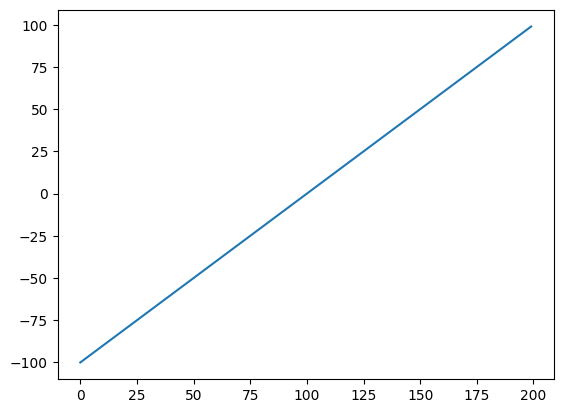

In [208]:
# Create a straight line tensor
x_line = torch.arange(-100, 100, 1)
plt.plot(x_line)

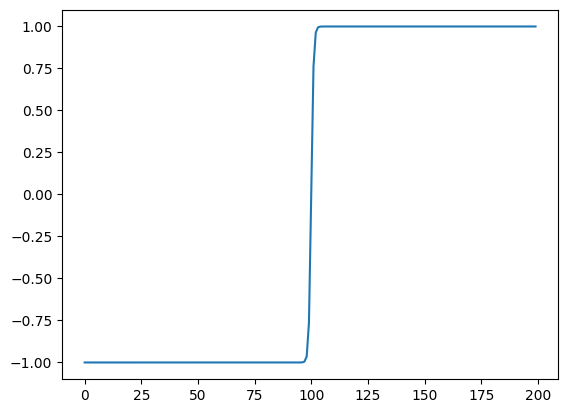

In [209]:
 plt.plot(torch.tanh(x_line))

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

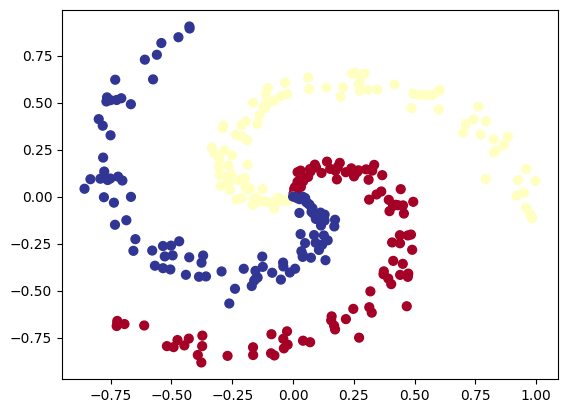

In [295]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [296]:
X[150], y[150]

(array([-0.10670726,  0.49364924]), 1)

In [297]:
# Turn data into tensors
import torch
from torch import nn
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size = 0.2, # 0.2 means 20% of data will be test (80% will be train)
                                                random_state=42
                                                )
print(f"LenXTrain: {len(X_train)}, LenXTest: {len(X_test)}, LenYTrain: {len(y_train)}, LenYtest: {len(y_test)}")
print(f"ShapeXTrain: {X_train.shape}, ShapeXTest: {X_test.shape}, ShapeYTrain: {y_train.shape}, ShapeYtest: {y_test.shape}")

LenXTrain: 240, LenXTest: 60, LenYTrain: 240, LenYtest: 60
ShapeXTrain: torch.Size([240, 2]), ShapeXTest: torch.Size([60, 2]), ShapeYTrain: torch.Size([240]), ShapeYtest: torch.Size([60])


In [298]:
# Let's calculuate the accuracy for when we fit our model
#!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [300]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class ExoSpiralModel(nn.Module):
  def __init__(self, inF, outF, hiddenF=8):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=inF, out_features=hiddenF),
        nn.Tanh(),
        nn.Linear(in_features=hiddenF, out_features=hiddenF),
        nn.Tanh(),
        nn.Linear(in_features=hiddenF, out_features=outF)
    )

  def forward(self, x):
    return self.layers(x)

# Instantiate model and send it to device
exo_spiral_model = ExoSpiralModel(2, 3).to(device)
exo_spiral_model

ExoSpiralModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [305]:
# Setup data to be device agnostic
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out first 10 untrained model outputs (forward pass)
y_logits = exo_spiral_model(X_train)
print(f"Logits: {y_logits[:10]}")

y_pred_probs = torch.softmax(exo_spiral_model(X_train)[:10], dim=1)
print(f"Pred probs: {y_pred_probs[:10]}")

y_labels = torch.softmax(exo_spiral_model(X_train)[:10], dim=1).argmax(dim=1)
print(f"Pred labels: {y_train[:10]}")

torch.float32 torch.float32 torch.int64 torch.int64
Logits: tensor([[-0.5432, -0.1160, -0.2329],
        [-0.5633, -0.1820, -0.2112],
        [-0.5553, -0.0939, -0.2545],
        [-0.6161, -0.2262, -0.2435],
        [-0.5826, -0.1515, -0.2605],
        [-0.5775, -0.1347, -0.2531],
        [-0.5692, -0.1168, -0.2552],
        [-0.4803, -0.0009, -0.2477],
        [-0.5909, -0.2004, -0.2231],
        [-0.6163, -0.2269, -0.2437]], grad_fn=<SliceBackward0>)
Pred probs: tensor([[0.2566, 0.3934, 0.3500],
        [0.2573, 0.3768, 0.3659],
        [0.2540, 0.4029, 0.3431],
        [0.2546, 0.3759, 0.3695],
        [0.2552, 0.3927, 0.3522],
        [0.2538, 0.3952, 0.3510],
        [0.2537, 0.3989, 0.3474],
        [0.2579, 0.4166, 0.3255],
        [0.2549, 0.3768, 0.3683],
        [0.2546, 0.3758, 0.3696]], grad_fn=<SliceBackward0>)
Pred labels: tensor([2, 0, 0, 1, 1, 0, 0, 2, 0, 1])


In [310]:

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(exo_spiral_model.parameters(),
                            lr=0.01)

In [311]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  exo_spiral_model.train()
  # 1. Forward pass
  logits = exo_spiral_model(X_train)
  preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
  # 2. Calculate the loss
  loss = loss_fn(logits, y_train)
  acc = acc_fn(preds, y_train)
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  exo_spiral_model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = exo_spiral_model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_preds, y_test)
  # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")
      #print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.0140, Acc: 0.32 | Test loss: 0.0001, Test acc: 1.00
Epoch: 100 | Loss: 0.0138, Acc: 0.32 | Test loss: 0.0001, Test acc: 1.00
Epoch: 200 | Loss: 0.0138, Acc: 0.32 | Test loss: 0.0001, Test acc: 1.00
Epoch: 300 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0001, Test acc: 1.00
Epoch: 400 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0001, Test acc: 1.00
Epoch: 500 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0000, Test acc: 1.00
Epoch: 600 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0000, Test acc: 1.00
Epoch: 700 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0000, Test acc: 1.00
Epoch: 800 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0000, Test acc: 1.00
Epoch: 900 | Loss: 0.0137, Acc: 0.32 | Test loss: 0.0000, Test acc: 1.00


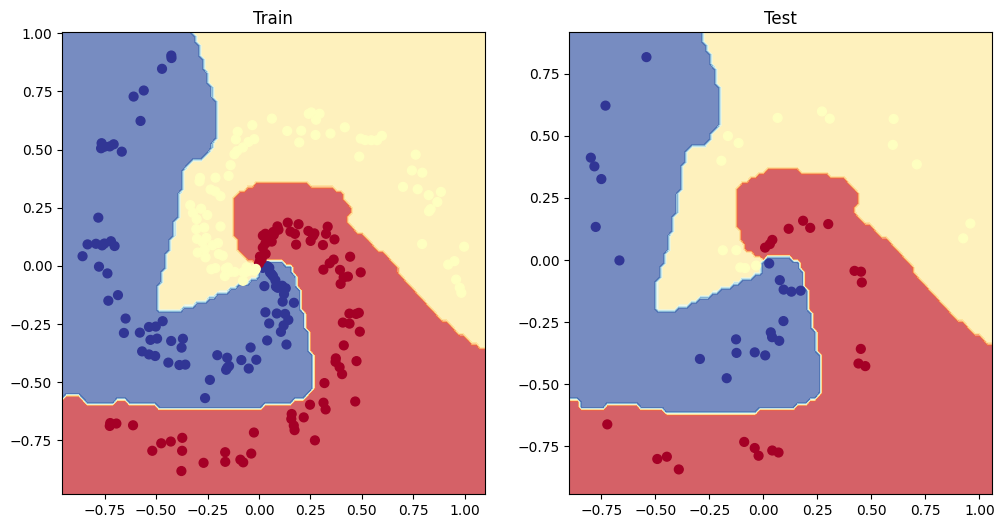

In [312]:
# Plot decision boudaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(exo_spiral_model,
                       X_train,
                       y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(exo_spiral_model,
                       X_test,
                       y_test)